In [1]:
import os
os.chdir('/home/conaire')
os.environ["JAX_PLATFORM_NAME"] = 'cpu'
import warnings
warnings.filterwarnings("ignore")

import jax
import jaxlib
import jax.numpy as np
import jax.lax as jl
import jax.random as jr
from jax.config import config
#config.update("jax_enable_x64", True)

import toliman
import toliman.constants as const
import toliman.math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import dLux
import optax
import equinox

jax.default_backend()

dLux: Jax is running in 32-bit, to enable 64-bit visit:
https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


'cpu'

# Create Model

In [2]:
# for i in tqdm.tqdm(range(50)):
#     model: object = dLux.Instrument(
#     optics = toliman.TolimanOptics(operate_in_static_mode = True, pixels_on_detector = 1024, pixels_in_pupil = 1024,
#                                    grating_amplitude = 2e-7, pixel_size =  dLux.utils.arcseconds_to_radians(0.3+i/200)),
#     detector = toliman.TolimanDetector(simulate_pixel_response = False),
#     sources = [toliman.AlphaCentauri()]
# )

In [3]:
# seed = 0
# key = jr.PRNGKey(seed)
# pscale = []

# for i in tqdm.tqdm(range(100000)):
#     key,_ = jr.split(key)
#     pscale.append(jr.uniform(key, minval = 0.3, maxval = 0.4))
                  
# plt.hist(pscale,bins = 50)
# print('')

In [4]:
%%time
model: object = dLux.Instrument(
    optics = toliman.TolimanOptics(operate_in_static_mode = True, pixels_on_detector = 1024, pixels_in_pupil = 1024,
                                   grating_amplitude = 2e-7, pixel_size =  dLux.utils.arcseconds_to_radians(0.3)),
    detector = toliman.TolimanDetector(simulate_pixel_response = False),
    sources = [toliman.AlphaCentauri()]
)

psf: float = model.model()
data_target: float = math.simulate_data(psf, 1)
data_target += np.min(data_target)

CPU times: user 1min 8s, sys: 10.4 s, total: 1min 19s
Wall time: 14.8 s


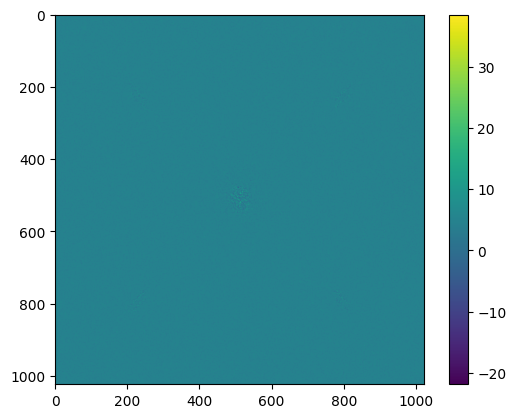

In [5]:
plt.imshow(psf-data_target)
plt.colorbar()

In [6]:
#@equinox.filter_jit
def loss(pscale, data_target):
    model_guess: object = dLux.Instrument(
    optics = toliman.TolimanOptics(operate_in_static_mode = True, pixels_on_detector = 1024, pixels_in_pupil = 1024,
                                   grating_amplitude = 2e-7, pixel_size =  dLux.utils.arcseconds_to_radians(pscale)),
    detector = toliman.TolimanDetector(simulate_pixel_response = False),
    sources = [toliman.AlphaCentauri()]
    )
    
    psf_guess: float = model_guess.model()
    data_guess: float = math.simulate_data(psf_guess, 1)
    
    #noise = np.sqrt(data_target)
    residual = (data_target - data_guess)#/noise
    
    chi2 = np.sum(residual**2)
    print(f'{chi2:.4e}')
    return chi2

In [7]:
%%time
test = loss(0.35, data_target)

2.4162e+07
CPU times: user 1min 5s, sys: 10.2 s, total: 1min 15s
Wall time: 11.3 s


In [10]:
%%time
start_learning_rate = 4.5e-2
max_iter = 200
param = 0.35

opt = optax.rmsprop(learning_rate=start_learning_rate)

gtol = 1e-3

opt = optax.inject_hyperparams(optax.adam)(learning_rate=start_learning_rate)
opt_state = opt.init(param)

# Do gradient descent
lr = start_learning_rate
for j in tqdm.tqdm(range(max_iter)):
    grads = jax.grad(loss)(param, data_target)

    # overall_gtol = np.sum(np.abs(grads))
    # print(overall_gtol)

    # if overall_gtol < gtol:
    #     print('Gtol satisfied')
    opt_state.hyperparams['learning_rate'] = lr
    updates, opt_state = opt.update(grads, opt_state)
    param = optax.apply_updates(param, updates)
    print(param)
    if j == max_iter - 1:
        print('Maximum iterations hit')

  0%|          | 0/200 [00:00<?, ?it/s]

2.4162e+07
0.35
2.4162e+07
0.35


KeyboardInterrupt: 